# iForest

In [1]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [2]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from os.path import join
import json
import datetime

import shap
from shap_selection import feature_selection

from sklearn.preprocessing import OneHotEncoder
import time

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

In [4]:
from src.load.functions import get_fs_dataset, fs_datasets_hyperparams
from src.plots.functions import plot_3d_surface, plot_2d_surface, boxplot_stability, lineplot_stability
from src.utils.functions import add_custom_repeating_sequence, add_sequence_to_dataframe, prepare_subsets
from src.optimization.functions import opt_value

# if we want to create an iteractive plot or not
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

## Credit card

**Dataset source**: http://odds.cs.stonybrook.edu/arrhythmia-dataset/ (data is transformed from .mat to .csv format)

Shebuti Rayana (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.

**Additional sources**:

Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. “Isolation forest.” 2008 Eighth IEEE International Conference on Data Mining. IEEE, 2008.

K. M. Ting, J. T. S. Chuan, and F. T. Liu. “Mass: A New Ranking Measure for Anomaly Detection.“, IEEE Transactions on Knowledge and Data Engineering, 2009.

F. Keller, E. Muller, K. Bohm.“HiCS: High-contrast subspaces for density-based outlier ranking.” ICDE, 2012.

In [5]:
dataset_id = 'creditcard'

data = get_fs_dataset(dataset_id, data_root)
hyper = fs_datasets_hyperparams(dataset_id)
data.shape

(284807, 29)

In [6]:
pd.pivot_table(data,
             values = 'V1',
               index = 'y', 
              aggfunc = 'count')

,V1
y,
0,284315
1,492


In [7]:
excluded_cols = []

### iForest

## Parameters

In [8]:
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")
df = pd.read_parquet(path_shap)

image_1 = os.path.join(data_root, "images", f'3d_precision_{dataset_id}.png')
image_2 = os.path.join(data_root, "images", f'3d_shap_index_{dataset_id}.png')
image_3 = os.path.join(data_root, "images", f'2d_precision_stability_{dataset_id}.png')
image_4 = os.path.join(data_root, "images", f'2d_boxplots_{dataset_id}.png')
image_5 = os.path.join(data_root, "images", f'2d_lineplots_{dataset_id}.png')
image_6 = os.path.join(data_root, "images", f'3d_precision_stability_{dataset_id}.png')

In [9]:
path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

fi_shap_all = pd.read_parquet(path_fi_shap)
df = pd.read_parquet(path_shap)
df = df[(df.n_estimators>=25) & (df.n_estimators<=600)]

df['shap_q1'] = df['shap_stab'].apply(lambda x: np.percentile(x, 75))
df['shap_q2'] = df['shap_stab'].apply(lambda x: np.percentile(x, 50))
df['shap_q3'] = df['shap_stab'].apply(lambda x: np.percentile(x, 25))

df['shap_ad_q2'] = df['shap_stab_ad'].apply(lambda x: np.percentile(x, 50))
df['stability index'] = df['shap_stab'].apply(lambda x: np.mean(x))

var = ['n_estimators', 'max_feats', 'n_feats', 'f1_median', 'precision', 'recall', 'model_stab', 'shap_stab', 'shap_q2', 'stability index', 'roc_auc']
df = df[var]

## Optimization

In [10]:
sorted_df = opt_value(df, lambda_=0.7, var2='stability index')

opt_x = int(sorted_df.iloc[0:1,:].n_estimators)
opt_y = int(sorted_df.iloc[0:1,:].n_feats)

sorted_df.head(5)

,n_estimators,max_feats,n_feats,f1_median,precision,recall,model_stab,shap_stab,shap_q2,stability index,roc_auc,opt_value
498,200,2,2,0.023767,0.012087,0.705584,0.967858,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.925737,0.893118,0.286182
499,200,2,2,0.023728,0.012067,0.705584,0.967858,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.925737,0.889532,0.286168
496,200,2,2,0.023586,0.011995,0.700508,0.967858,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.925737,0.891265,0.286118
497,200,2,2,0.023419,0.011910,0.695431,0.967858,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.925737,0.885298,0.286058
495,200,2,2,0.022589,0.011488,0.670051,0.967858,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.925737,0.882054,0.285763


## Visualization of the results

In [11]:
# Find the index of the maximum 'n_feat' in each 'n_estimators' and 'n_feats' group
idx = df.groupby(['n_estimators', 'n_feats'])['max_feats'].idxmax()
# Filter the DataFrame to keep only the rows with the maximum 'n_feat' per group
df_n_trees = df.loc[idx].reset_index(drop=True)

,n_estimators,max_feats,n_feats,f1_median,precision,recall,model_stab,shap_stab,shap_q2,stability index,roc_auc,opt_value
0,25,2,2,0.023489,0.011946,0.695431,0.886426,"[1.0, 0.5101020514433645, 1.0, 0.6000000000000...",1.000000,0.807264,0.879922,0.250542
1,25,4,4,0.024672,0.012549,0.725888,0.938712,"[0.7199892264322878, 0.8697303934264774, 0.685...",0.817678,0.770038,0.890417,0.239796
2,25,6,6,0.024236,0.012325,0.720812,0.949239,"[0.5274683753528595, 0.8290738180680169, 0.733...",0.811960,0.784560,0.875574,0.243996
3,25,9,9,0.027694,0.014086,0.817259,0.949599,"[0.623282317012408, 0.7931257964564852, 0.6206...",0.745008,0.724948,0.928849,0.227345
4,25,11,11,0.027041,0.013752,0.802030,0.951930,"[0.7436645523532683, 0.6792048476200001, 0.742...",0.735826,0.719553,0.923622,0.225493
5,25,14,14,0.029320,0.014914,0.862944,0.897356,"[0.7252418315686138, 0.7779743737360896, 0.738...",0.663815,0.654941,0.946627,0.206922
6,25,17,17,0.028966,0.014733,0.852792,0.919826,"[0.6765272518506014, 0.6551234245572628, 0.809...",0.661340,0.653329,0.930953,0.206312
7,25,20,20,0.028376,0.014431,0.842640,0.902452,"[0.626642837408812, 0.6289201741977112, 0.6920...",0.630681,0.626864,0.927379,0.198161
8,25,24,24,0.029298,0.014902,0.862944,0.904989,"[0.5722506833320824, 0.580155662302511, 0.6033...",0.598529,0.597978,0.937640,0.189825
9,25,28,28,0.029452,0.014979,0.873096,0.904514,"[0.5568142001300027, 0.4817444232599011, 0.549...",0.525127,0.527314,0.951460,0.168679


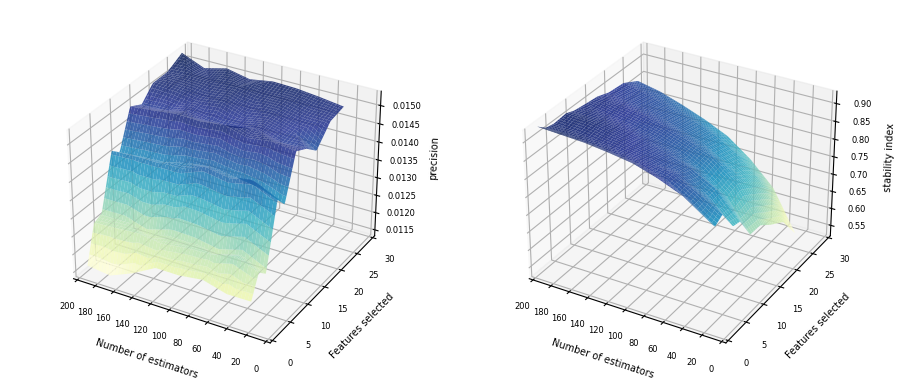

In [45]:
plt.figure(figsize=(9, 3.8))  # Overall figure size

# First plot
ax1 = plt.subplot(1, 2, 1, projection='3d')
plot_3d_surface(df_n_trees, 'n_estimators', 'n_feats', 'precision', ax1, fontsize_title=7, fontsize_axes=6, cmap='YlGnBu', x_step=20, y_step=5, opt_color='red', title='', alpha=0.85, edgecolor=None)

ax2 = plt.subplot(1, 2, 2, projection='3d')
plot_3d_surface(df_n_trees, 'n_estimators', 'n_feats', 'stability index', ax2, fontsize_title=7, fontsize_axes=6, cmap='YlGnBu', x_step=20, y_step=5, opt_color='red', alpha=.9, edgecolor=None)

plt.tight_layout()  # Adjust layout


# Adjust the spacing between the plots
plt.subplots_adjust(wspace=0.1)  # Adjust the width space as needed for better visualization

plt.savefig(image_6, bbox_inches='tight', pad_inches=0.3)  # Save the plot to a file
plt.show()

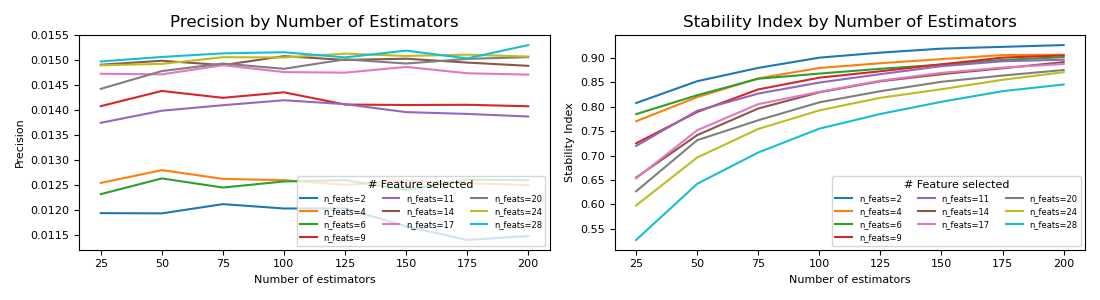

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3))  # 1 row, 2 columns

plot_2d_surface(df_n_trees, axs, fontsize_title=12, fontsize_axes=8, save_path=image_3)

In [14]:
# Sorting the DataFrame
df = df.sort_values(by=['n_estimators', 'n_feats', 'max_feats'], ascending=[True, False, False])

# Preparing subsets
ranks = [1, 2, 4, 6, 8, 10]  # Define ranks of interest
max_feats = [1, 2, 3, 4, 5]  # Define max_feats of interest

# Adding sequences
df = add_custom_repeating_sequence(df, 'rank_max_feats', len(max_feats))
sequence = np.concatenate([np.repeat(i, len(max_feats)) for i in range(1, 12)])  # Creating a sequence from 1 to 11, each repeating 5 times
df = add_sequence_to_dataframe(df, sequence, 'rank_feats')

# Assigning rank based on group
df['rank_estimators'] = df.groupby(['n_feats', 'rank_max_feats']).cumcount() + 1

subsets = prepare_subsets(df, ranks, max_feats)

# Now, you can access your subsets like subsets['df1_1'], subsets['df2_1'], ..., subsets['df10_1'].

In [15]:
subsets

{'df1_1':      n_estimators  max_feats  n_feats  f1_median  precision    recall  \
 159            25         28       28   0.029452   0.014979  0.873096   
 159            25         28       28   0.029452   0.014979  0.873096   
 159            25         28       28   0.029452   0.014979  0.873096   
 159            25         28       28   0.029452   0.014979  0.873096   
 159            25         28       28   0.029452   0.014979  0.873096   
 ..            ...        ...      ...        ...        ...       ...   
 544           200         28       28   0.030095   0.015307  0.888325   
 544           200         28       28   0.030095   0.015307  0.888325   
 544           200         28       28   0.030095   0.015307  0.888325   
 544           200         28       28   0.030095   0.015307  0.888325   
 544           200         28       28   0.030095   0.015307  0.888325   
 
      model_stab  shap_stab   shap_q2  stability index   roc_auc  opt_value  \
 159    0.904514   0.5

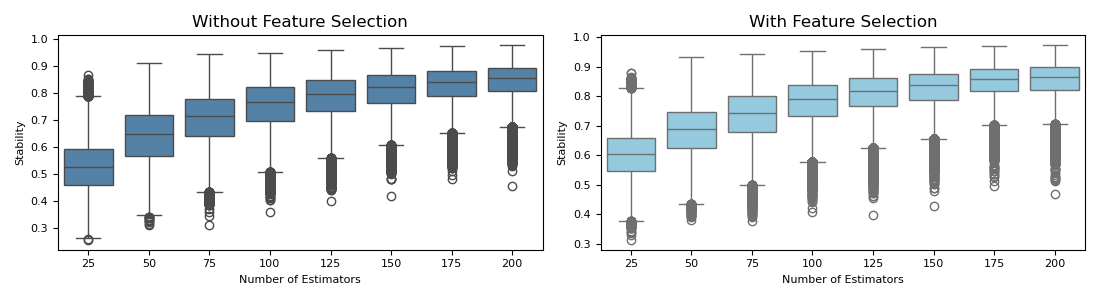

In [16]:
# Define your DataFrame for without feature selection `df0` and with feature selection `df1`
fig, axs = plt.subplots(1, 2, figsize=(11, 3))  # Create a figure and a 2x1 grid of subplots

# Call the boxplot_stability function
boxplot_stability(subsets['df1_1'], subsets['df2_1'], axs, fontsize_title=12, fontsize_axes=8, title='Comparison of SHAP Stability', save_path=image_4)

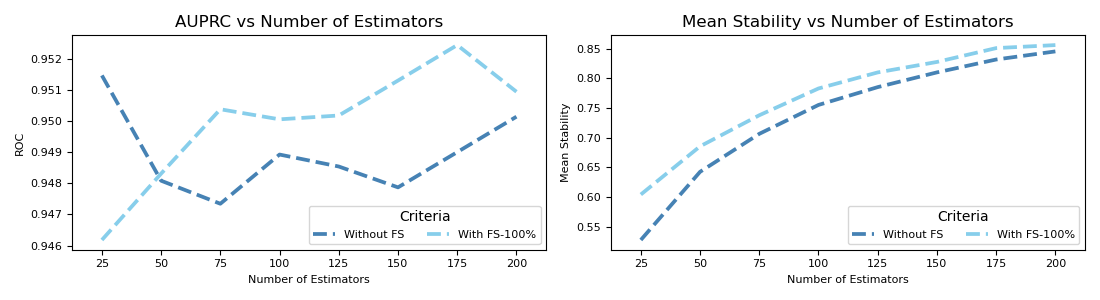

In [17]:
dataframes = [subsets['df1_1'], subsets['df2_1']] #, df21, df31, df41, df51

fig, axs = plt.subplots(1, 2, figsize=(11, 3))  # Create a figure and a 2x1 grid of subplots

# Assume `dataframes` is a list of DataFrame objects you want to plot
# Call the lineplot_stability function
lineplot_stability(dataframes, axs, fontsize_title=12, fontsize_axes=8, save_path=image_5)


In [18]:
df_compare = subsets['df1_1']
df_compare = df_compare[(df_compare.n_estimators==100) & (df_compare.n_feats==max(df_compare.n_feats)) & (df_compare.max_feats==max(df_compare.max_feats))]
var = ['n_estimators', 'n_feats', 'max_feats', 'roc_auc', 'precision', 'recall', 'f1_median', 'stability index']
df_result = df_compare[var].drop_duplicates()
roc = df_result.roc_auc
precision = df_result.precision
recall = df_result.recall
f1_median = df_result.f1_median
df_result

,n_estimators,n_feats,max_feats,roc_auc,precision,recall,f1_median,stability index
324,100,28,28,0.94892,0.015163,0.878173,0.029812,0.75493


In [19]:
df[var][
(df.roc_auc >= float(roc)) &
(df.precision >= float(precision)) & 
(df.recall >= int(recall)) & 
(df.f1_median>=int(f1_median))
].sort_values('stability index', ascending=False).drop_duplicates()

,n_estimators,n_feats,max_feats,roc_auc,precision,recall,f1_median,stability index
547,200,28,16,0.950937,0.015344,0.888325,0.030167,0.855822
487,175,28,16,0.952434,0.015307,0.888325,0.030095,0.850727
546,200,28,11,0.952367,0.015277,0.883249,0.030034,0.849807
549,200,28,28,0.950136,0.015307,0.888325,0.030095,0.845160
491,175,28,11,0.953111,0.015451,0.893401,0.030376,0.841184
432,150,28,16,0.951295,0.015339,0.888325,0.030157,0.827386
436,150,28,11,0.954411,0.015481,0.893401,0.030434,0.826684
382,125,28,16,0.950174,0.015240,0.883249,0.029964,0.809735
381,125,28,11,0.953767,0.015183,0.878173,0.029851,0.805476
326,100,28,11,0.954298,0.015224,0.883249,0.029933,0.786772


In [20]:
df[var][
(df.n_estimators >= 200) &
(df.n_feats >= 28)
].sort_values('stability index', ascending=False).drop_duplicates()

,n_estimators,n_feats,max_feats,roc_auc,precision,recall,f1_median,stability index
542,200,28,16,0.950937,0.015344,0.888325,0.030167,0.855822
543,200,28,22,0.947240,0.015049,0.878173,0.029590,0.852048
541,200,28,11,0.952367,0.015277,0.883249,0.030034,0.849807
540,200,28,5,0.945980,0.014986,0.873096,0.029467,0.848552
544,200,28,28,0.950136,0.015307,0.888325,0.030095,0.845160
